#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

### **(2) 라이브러리 설치 및 불러오기**

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [340]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [341]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [342]:
mydataset = joblib.load('myinterested_file_2.pkl')
mydataset

,Date,Qty,WTI_Price,CustomerCount,IsHoliday,IsOverQtyMonth,IsSummer,TotalPrice,year_2015,year_2016,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2014-01-01,51,95.14,3865,1,0,0,255,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-02,76,95.14,4422,0,0,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-01-03,74,93.66,4167,0,0,0,370,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-01-04,78,93.12,5341,1,0,0,390,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-01-05,88,93.12,5123,1,0,0,440,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91,53.99,4549,0,0,0,455,0,0,...,0,0,0,0,0,0,0,0,0,0
1151,2017-02-25,105,54.04,4619,1,0,0,525,0,0,...,0,0,0,0,0,0,0,0,0,0
1152,2017-02-26,108,54.04,3877,1,0,0,540,0,0,...,0,0,0,0,0,0,0,0,0,0
1153,2017-02-27,78,54.04,3961,0,0,0,390,0,0,...,0,0,0,0,0,0,0,0,0,0


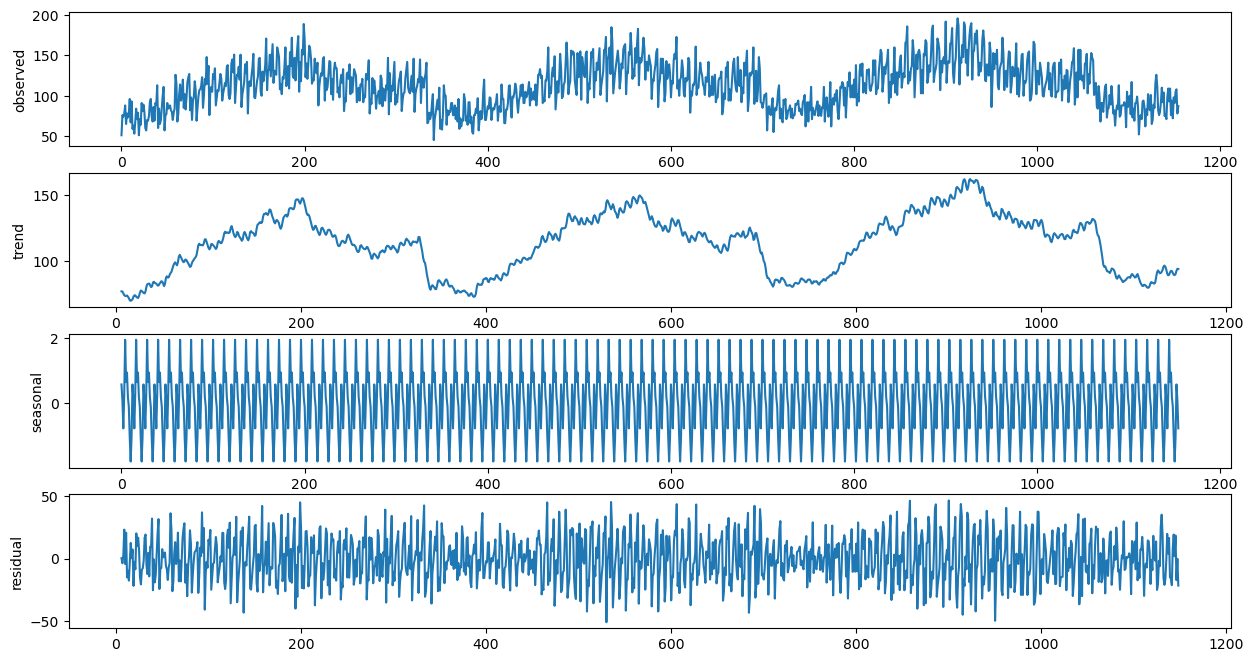

In [343]:
decomp = sm.tsa.seasonal_decompose(mydataset['Qty'], model = 'additive', period = 12)
result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

plt.figure(figsize=(15, 8))

plt.subplot(4,1,1)
plt.plot(result['observed'])
plt.ylabel('observed')

plt.subplot(4,1,2)
plt.plot(result['trend'])
plt.ylabel('trend')

plt.subplot(4,1,3)
plt.plot(result['seasonal'])
plt.ylabel('seasonal')

plt.subplot(4,1,4)
plt.plot(result['residual'])
plt.ylabel('residual')
plt.show()

# 시계열 분해 데이터 (추세,계절성,잔차)

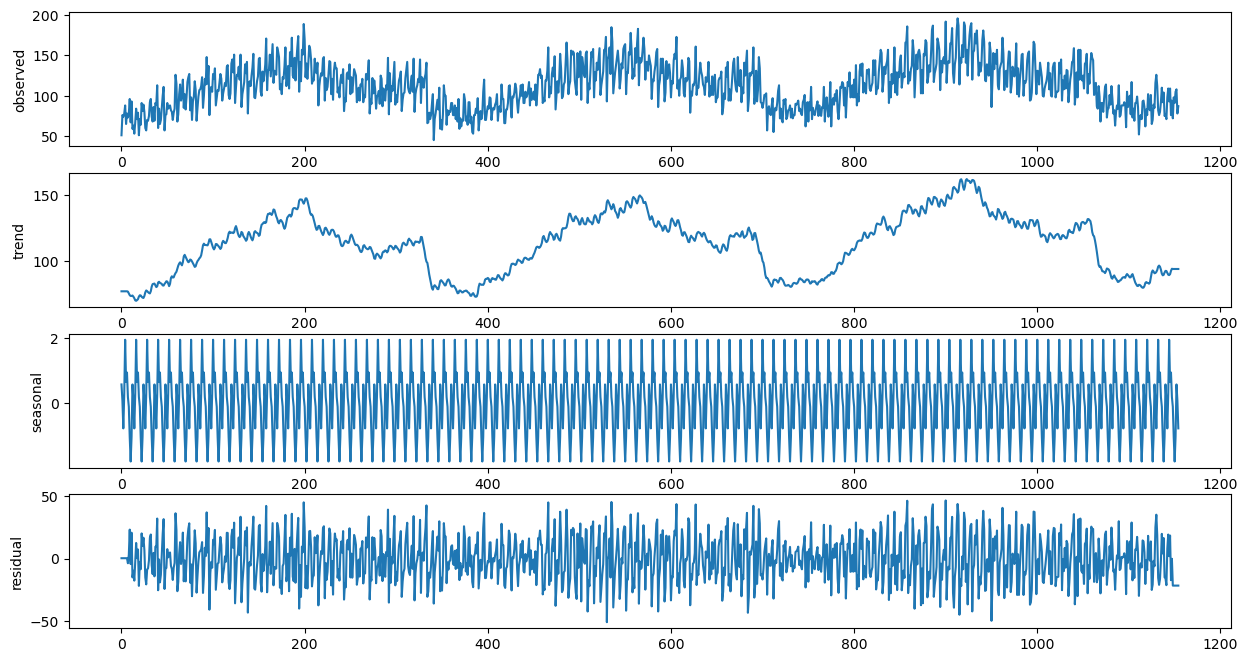

In [344]:
result = result.bfill()
result = result.ffill()

plt.figure(figsize=(15, 8))

plt.subplot(4,1,1)
plt.plot(result['observed'])
plt.ylabel('observed')

plt.subplot(4,1,2)
plt.plot(result['trend'])
plt.ylabel('trend')

plt.subplot(4,1,3)
plt.plot(result['seasonal'])
plt.ylabel('seasonal')

plt.subplot(4,1,4)
plt.plot(result['residual'])
plt.ylabel('residual')
plt.show()

result = result[['trend','seasonal','residual']]

In [345]:
my_dataset = pd.concat([mydataset,result],axis=1)
my_dataset.drop(columns='Date',inplace=True)

In [346]:
my_dataset.columns

Index(['Qty', 'WTI_Price', 'CustomerCount', 'IsHoliday', 'IsOverQtyMonth',
       'IsSummer', 'TotalPrice', 'year_2015', 'year_2016', 'year_2017',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'trend', 'seasonal', 'residual'],
      dtype='object')

# 정규화 처리 필요

In [347]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

my_dataset['FutureQty'] = my_dataset['Qty'].shift(-2) # 이틀 뒤의 판매량 예측
target = 'FutureQty'

X = my_dataset.drop(columns=target)
y = my_dataset[target]
X_train = X[:-60]
y_train = y[:-60]
X_valid = X[-60:-2]
y_valid = y[-60:-2]

X_train[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']] = scaler.fit_transform(X_train[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']])
X_valid[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']]= scaler.transform(X_valid[['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice']])
X_train

,Qty,WTI_Price,CustomerCount,IsHoliday,IsOverQtyMonth,IsSummer,TotalPrice,year_2015,year_2016,year_2017,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend,seasonal,residual
0,-2.253228,1.374902,-0.738606,1,0,0,-2.253228,0,0,0,...,0,0,0,0,0,0,0,76.750000,0.583969,0.298309
1,-1.363334,1.374902,0.022695,0,0,0,-1.363334,0,0,0,...,0,0,0,0,0,0,0,76.750000,0.091425,0.298309
2,-1.434526,1.314181,-0.325836,0,0,0,-1.434526,0,0,0,...,0,0,0,0,0,0,0,76.750000,-0.767785,0.298309
3,-1.292143,1.292027,1.278773,1,0,0,-1.292143,0,0,0,...,0,0,0,0,0,0,0,76.750000,0.286601,0.298309
4,-0.936185,1.292027,0.980813,1,0,0,-0.936185,0,0,0,...,0,0,0,0,0,0,0,76.750000,1.959408,0.298309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,-1.434526,-0.361381,1.721612,1,0,0,-1.434526,0,1,0,...,0,0,0,0,0,0,1,84.958333,-1.786645,-9.171688
1091,-1.363334,-0.361381,0.368492,0,0,0,-1.363334,0,1,0,...,0,0,0,0,0,0,1,85.166667,-1.029189,-8.137478
1092,-0.936185,-0.312559,1.080589,0,0,0,-0.936185,0,1,0,...,0,0,0,0,0,0,1,86.125000,0.583969,1.291031
1093,-0.936185,-0.321174,0.542074,0,0,0,-0.936185,0,1,0,...,0,0,0,0,0,0,1,87.083333,0.091425,0.825241


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [348]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [349]:
X_train.columns

Index(['Qty', 'WTI_Price', 'CustomerCount', 'IsHoliday', 'IsOverQtyMonth',
       'IsSummer', 'TotalPrice', 'year_2015', 'year_2016', 'year_2017',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'trend', 'seasonal', 'residual'],
      dtype='object')

## **(1) LSTM 모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [350]:
timesteps = 14
X_train,y_train = temporalize(X_train,y_train,timesteps)
X_valid,y_valid = temporalize(X_valid,y_valid,timesteps)

In [351]:
X_train

array([[[-2.25322845e+00,  1.37490216e+00, -7.38605849e-01, ...,
          7.67500000e+01,  5.83969146e-01,  2.98308815e-01],
        [-1.36333422e+00,  1.37490216e+00,  2.26949174e-02, ...,
          7.67500000e+01,  9.14252863e-02,  2.98308815e-01],
        [-1.43452576e+00,  1.31418147e+00, -3.25835954e-01, ...,
          7.67500000e+01, -7.67785240e-01,  2.98308815e-01],
        ...,
        [-7.58206140e-01,  1.22351071e+00,  6.10413642e-01, ...,
          7.32500000e+01, -1.02918875e+00,  2.07791887e+01],
        [-1.96846230e+00,  1.22351071e+00, -6.73000038e-01, ...,
          7.35416667e+01,  5.83969146e-01, -1.51256358e+01],
        [-1.82607922e+00,  1.25222995e+00, -1.15547611e+00, ...,
          7.26666667e+01,  9.14252863e-02, -9.75809195e+00]],

       [[-1.36333422e+00,  1.37490216e+00,  2.26949174e-02, ...,
          7.67500000e+01,  9.14252863e-02,  2.98308815e-01],
        [-1.43452576e+00,  1.31418147e+00, -3.25835954e-01, ...,
          7.67500000e+01, -7.67785240e

* **모델링**

In [352]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping,ModelCheckpoint

model = Sequential()
model.add(LSTM(units=128,return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0005), loss=MeanSquaredError())
es = EarlyStopping(monitor='val_loss',patience=30)
mc = ModelCheckpoint('CheckPoint/best_lstm.keras',save_best_only=True,monitor='val_loss',mode='min')
# 모델 훈련
model.fit(X_train, y_train,validation_data=[X_valid,y_valid], epochs=100, batch_size=8, callbacks=[es,mc])

# 예측
predictions = model.predict(X_valid)


Epoch 1/100
136/136 [==============================] - 3s 8ms/step - loss: 12013.7842 - val_loss: 5297.5527
Epoch 2/100
136/136 [==============================] - 1s 5ms/step - loss: 9309.7881 - val_loss: 3858.3684
Epoch 3/100
136/136 [==============================] - 1s 5ms/step - loss: 7633.2749 - val_loss: 2952.8857
Epoch 4/100
136/136 [==============================] - 1s 4ms/step - loss: 6453.5991 - val_loss: 2261.9041
Epoch 5/100
136/136 [==============================] - 1s 4ms/step - loss: 5457.3623 - val_loss: 1711.7521
Epoch 6/100
136/136 [==============================] - 1s 4ms/step - loss: 4622.4741 - val_loss: 1274.7211
Epoch 7/100
136/136 [==============================] - 1s 4ms/step - loss: 3895.0037 - val_loss: 920.1961
Epoch 8/100
136/136 [==============================] - 1s 4ms/step - loss: 3282.4270 - val_loss: 662.1378
Epoch 9/100
136/136 [==============================] - 1s 4ms/step - loss: 2773.0447 - val_loss: 476.5996
Epoch 10/100
136/136 [=================

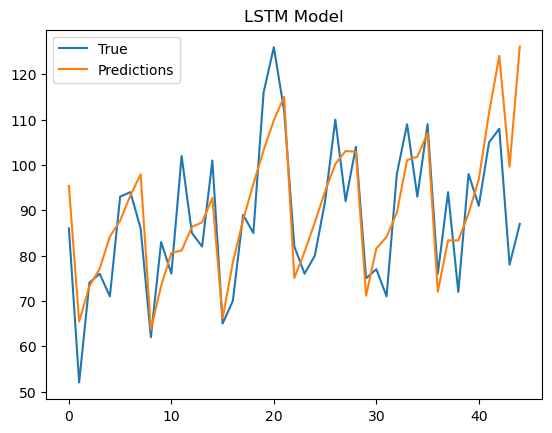

In [353]:
plt.figure()
plt.plot(y_valid,label='True')
plt.plot(predictions[:,0],label='Predictions')
plt.title("LSTM Model")
plt.legend()
plt.show()

In [354]:
from sklearn.metrics import mean_absolute_error,r2_score
print(r2_score(y_valid,predictions))
mean_absolute_error(y_valid,predictions)

0.5083885725974713


8.379097408718533

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [355]:
oil_price_test = pd.read_csv('test/oil_price_test.csv')
orders_test = pd.read_csv('test/orders_test.csv')
sales_test = pd.read_csv('test/sales_test.csv')
products = pd.read_csv('test/products.csv')
stores = pd.read_csv('test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

dataset_test = pd.merge(sales_test,products,how='left',on='Product_ID') # 판매수량 및 가격과 리드타임과 정보에 관한 정보 merge
dataset_test = pd.merge(dataset_test,stores,how='left',on='Store_ID') # 매장에 관한 정보도 추가
dataset_test = pd.merge(dataset_test,oil_price_test,how='left',on='Date') # 매장에 대한 유가정보도 추가
dataset_test = pd.merge(dataset_test,orders_test,how='left',on=['Date','Store_ID']) # 매장에 대한 고객 방문 수 정보 추가
myinterested_test = dataset_test.loc[(dataset_test['Store_ID']==44) & (dataset_test['Product_ID']==42)]

# 미국 연방 공휴일 기준
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.impute import KNNImputer 
from sklearn.preprocessing import StandardScaler

def preprocessing4predict(test_dataset,CAT_COL = ['year','weekday','month'], NUM_COL = ['Qty','CustomerCount','WTI_Price','CustomerCount','TotalPrice'],train_dataset=my_dataset):
    test_dataset.drop(columns=['Product_Code','Store_Type','SubCategory','Category','Store_ID','Product_ID','State','City','LeadTime'],inplace=True)
    test_dataset.reset_index(drop=True,inplace=True) # 인덱스 번호 초기화
    test_dataset['Qty'].astype(int)
    test_dataset['year'] = test_dataset['Date'].dt.year
    test_dataset['weekday'] = test_dataset['Date'].dt.weekday
    test_dataset['month'] = test_dataset['Date'].dt.month
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays()

    test_dataset['holiday'] = np.where((test_dataset['weekday'] >= 5) | (test_dataset['Date'].isin(holidays)), 1, 0)
    test_dataset['OverQtyMonth'] = test_dataset['month'].map({1:0,2:0,3:0,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:0}) # 판매량 평균을 넘어가는 달에 대해 추가 칼럼으로 0,1을 만들어주었다.
    test_dataset['Summer'] = test_dataset['month'].map({5:1,6:1,7:1,8:1,1:0,2:0,3:0,4:0,9:0,10:0,11:0,12:0}) # 여름에 잘 팔리는 상품인 것 같아서 여름인가? 에 대한 칼럼을 추가로 만들어줌
    test_dataset['WTI_Price'] = test_dataset['WTI_Price'].bfill() # 유가 데이터는 주변 데이터와 비슷하거나 동일할 것이라고 생각되어 bbfill 근접한 데이터를 사용해서 채워줌

    imputer = KNNImputer(n_neighbors=3)
    test_dataset['CustomerCount'] = imputer.fit_transform(test_dataset[['Qty','CustomerCount','holiday']])[:,1] # 위에서 공휴일과 아닐때의 방문 차이가 있으니 공휴일과 판매량도 고려해서 결측치 해결
    test_dataset[['CustomerCount','Qty']] = test_dataset[['CustomerCount','Qty']].astype(int)
    test_dataset = test_dataset.rename(columns= {'holiday':'IsHoliday','Summer':'IsSummer','OverQtyMonth':'IsOverQtyMonth'})
    test_dataset['TotalPrice'] = test_dataset['Price']*test_dataset['Qty']
    test_dataset.drop(columns='Price',inplace=True)

    test_dataset = pd.get_dummies(test_dataset,columns=CAT_COL,dtype=int) # 순위가 없으므로 year와 weekday와 month는 원핫인코딩으로 학습 필요
    decomp = sm.tsa.seasonal_decompose(test_dataset['Qty'], model = 'additive', period = 12)
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})
    result = result.bfill()
    result = result.ffill()
    result = result[['trend','seasonal','residual']]
    
    test_dataset = pd.concat([test_dataset,result],axis=1)
    test_dataset.drop(columns='Date',inplace=True)
    test_dataset['FutureQty'] = test_dataset['Qty'].shift(-2) # 이틀 뒤의 판매량 예측
    target = 'FutureQty'

    X_test = test_dataset.drop(columns=target)
    y_test = test_dataset[target]

    scaler = StandardScaler()
    scaler.fit(train_dataset[NUM_COL])
    X_test[NUM_COL] = scaler.transform(X_test[NUM_COL])
    return X_test,y_test

X_test,y_test = preprocessing4predict(myinterested_test,train_dataset=my_dataset)

X_test['year_2015'] = [0] * 31
X_test['year_2016'] = [0] * 31
X_test['month_2'] = [0] * 31
X_test['month_4'] = [0] * 31
X_test['month_5'] = [0] * 31
X_test['month_6'] = [0] * 31
X_test['month_7'] = [0] * 31
X_test['month_8'] = [0] * 31
X_test['month_9'] = [0] * 31
X_test['month_10'] = [0] * 31
X_test['month_11'] = [0] * 31
X_test['month_12'] = [0] * 31
new_column_order = ['Qty', 'WTI_Price', 'CustomerCount', 'IsHoliday', 'IsOverQtyMonth',
                    'IsSummer', 'TotalPrice', 'year_2015', 'year_2016', 'year_2017',
                    'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
                    'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                    'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
                    'trend', 'seasonal', 'residual']

X_test = X_test[new_column_order]

['Qty', 'WTI_Price', 'CustomerCount', 'IsHoliday', 'IsOverQtyMonth',
       'IsSummer', 'TotalPrice', 'year_2015', 'year_2016', 'year_2017',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'trend', 'seasonal', 'residual']

In [356]:
timesteps = 14

X_test,y_test = temporalize(X_test,y_test,timesteps) # 3 차원으로 변경

* 예측해보기

1/1 [==============================] - 0s 16ms/step


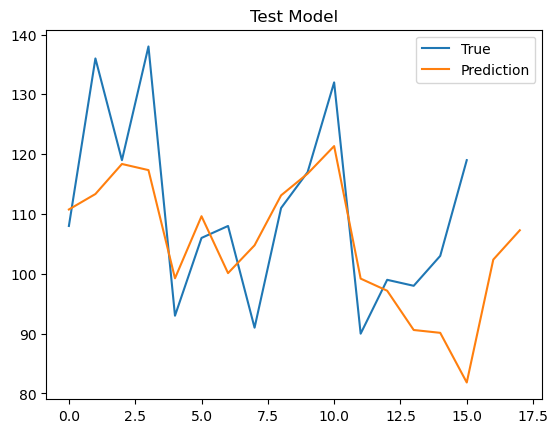

In [360]:
y_test_predict = model.predict(X_test)
plt.figure()
plt.plot(y_test,label='True')
plt.plot(y_test_predict,label='Prediction')
plt.title("Test Model")
plt.legend()
plt.show()

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [230]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**
